<a href="https://colab.research.google.com/github/JulianSchmidtke/CAPTUM/blob/main/AsuD_CAPTUM_v0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/JulianSchmidtke/CAPTUM.git

Cloning into 'CAPTUM'...
remote: Enumerating objects: 487, done.
remote: Counting objects: 100% (487/487), done.
remote: Compressing objects: 100% (464/464), done.
remote: Total 487 (delta 26), reused 463 (delta 20), pack-reused 0
Receiving objects: 100% (487/487), 5.24 MiB | 9.95 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import nltk, os
import pandas as pd
import numpy as np

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [38]:
#Arbeitsverzeichnis auf das Ordnerverzeichnis ändern, in welchem die Daten liegen (txt-Format)

cwd = os.getcwd()
nwd = r'/content/CAPTUM/files'

os.chdir(nwd)

#Speichern der Dateinamen in einem Array
files = os.listdir()
df_files = pd.DataFrame(files, columns=['Filepath'])
df_files

,Filepath
0,CAPTUM_Allergic Diseases_Omalizumab_Kasperska-...
1,CAPTUM_ASST_serverity_Chen 2017.pdf_out_text...
2,CAPTUM_Anti-IgE_TPO_Turk 2016.pdf_out_text.txt
3,CAPTUM_Severity_Duration_Amin 2018.pdf_out_tex...
4,CAPTUM_Total IgE_Duration_Choi 2018.pdf_out_te...
...,...
1041,CAPTUM_Anti-IgE_Thyroglobulin_Sun 2014.pdf_out...
1042,CAPTUM_D-Dimer_Antihistamine_Montjoye 2020.pdf...
1043,CAPTUM_Basophil_Antihistamine_Uysal 2016.pdf_o...
1044,CAPTUM_D-Dimer_Omalizumab_Asero 2017 .pdf_out...


In [39]:
# create checksum for each file to identify duplicates
# https://stackoverflow.com/questions/16874598/how-do-i-calculate-the-md5-checksum-of-a-file-in-python#16876405
import hashlib
def get_checksum(filepath: str) -> str:
    # Open,close, read file and calculate MD5 on its contents 
    with open(filepath, 'rb') as file_to_check:
        # read contents of the file
        data = file_to_check.read()    
        # pipe contents of the file through
        return hashlib.md5(data).hexdigest()
df_files['Checksum'] = df_files['Filepath'].apply(get_checksum)
df_files

,Filepath,Checksum
0,CAPTUM_Allergic Diseases_Omalizumab_Kasperska-...,2cf68c89d16834a7cb69b736d4549c29
1,CAPTUM_ASST_serverity_Chen 2017.pdf_out_text...,b5c098eb3d4c2aa1f50c56fe8b7a4053
2,CAPTUM_Anti-IgE_TPO_Turk 2016.pdf_out_text.txt,6d67aafe0f7a5b6187f44c0061bb3a7b
3,CAPTUM_Severity_Duration_Amin 2018.pdf_out_tex...,c6a6bb5005722b996a3837401293d274
4,CAPTUM_Total IgE_Duration_Choi 2018.pdf_out_te...,d73f26b1f01d360d414e4f4648729f11
...,...,...
1041,CAPTUM_Anti-IgE_Thyroglobulin_Sun 2014.pdf_out...,8d90f8e8cb53382f4c557d26d7a553bc
1042,CAPTUM_D-Dimer_Antihistamine_Montjoye 2020.pdf...,5492f2ac1e413b91c6c99d02d3bbbd28
1043,CAPTUM_Basophil_Antihistamine_Uysal 2016.pdf_o...,a86431127af09c8de0863de2f261a361
1044,CAPTUM_D-Dimer_Omalizumab_Asero 2017 .pdf_out...,e2bfbe03a410839dc840d90601cb42cc


In [43]:
fileNameTags = list(map(lambda fn: fn.split('_')[0:-2],df_files['Filepath']))


df_files['Name'] = [fNT[-1] for fNT in fileNameTags]
df_files['Tags'] = [fNT[1:-1] for fNT in fileNameTags]
df_files['Year'] = [fY[-8:-4] for fY in fileName]
df_files['Authors'] = [fN.split(' ')[0] for fN in fileName]

df_files

,Filepath,Checksum,Name,Tags,Year,Authors
0,CAPTUM_Allergic Diseases_Omalizumab_Kasperska-...,2cf68c89d16834a7cb69b736d4549c29,Kasperska-Zajac 2016.pdf,"[Allergic Diseases, Omalizumab]",2016,Kasperska-Zajac
1,CAPTUM_ASST_serverity_Chen 2017.pdf_out_text...,b5c098eb3d4c2aa1f50c56fe8b7a4053,Chen 2017.pdf,"[ASST, serverity]",2017,Chen
2,CAPTUM_Anti-IgE_TPO_Turk 2016.pdf_out_text.txt,6d67aafe0f7a5b6187f44c0061bb3a7b,Turk 2016.pdf,"[Anti-IgE, TPO]",2016,Turk
3,CAPTUM_Severity_Duration_Amin 2018.pdf_out_tex...,c6a6bb5005722b996a3837401293d274,Amin 2018.pdf,"[Severity, Duration]",2018,Amin
4,CAPTUM_Total IgE_Duration_Choi 2018.pdf_out_te...,d73f26b1f01d360d414e4f4648729f11,Choi 2018.pdf,"[Total IgE, Duration]",2018,Choi
...,...,...,...,...,...,...
1041,CAPTUM_Anti-IgE_Thyroglobulin_Sun 2014.pdf_out...,8d90f8e8cb53382f4c557d26d7a553bc,Sun 2014.pdf,"[Anti-IgE, Thyroglobulin]",2014,Sun
1042,CAPTUM_D-Dimer_Antihistamine_Montjoye 2020.pdf...,5492f2ac1e413b91c6c99d02d3bbbd28,Montjoye 2020.pdf,"[D-Dimer, Antihistamine]",2020,Montjoye
1043,CAPTUM_Basophil_Antihistamine_Uysal 2016.pdf_o...,a86431127af09c8de0863de2f261a361,Uysal 2016.pdf,"[Basophil, Antihistamine]",2016,Uysal
1044,CAPTUM_D-Dimer_Omalizumab_Asero 2017 .pdf_out...,e2bfbe03a410839dc840d90601cb42cc,Asero 2017 .pdf,"[D-Dimer, Omalizumab]",17,Asero


In [49]:
# create dataframe for further analytics w/o the duplicate articles
df_analyze = df_files.drop_duplicates(subset=['Checksum'], keep='first')
df_analyze.reset_index(inplace=True, drop=True)
df_analyze = df_analyze.loc[:,['Authors','Year','Tags']]
df_analyze

,Authors,Year,Tags
0,Kasperska-Zajac,2016,"[Allergic Diseases, Omalizumab]"
1,Chen,2017,"[ASST, serverity]"
2,Turk,2016,"[Anti-IgE, TPO]"
3,Amin,2018,"[Severity, Duration]"
4,Choi,2018,"[Total IgE, Duration]"
...,...,...,...
449,Altrichter,2020,"[Eosinophil, Basophil]"
450,Damask,2020,"[Allergic Diseases, Omalizumab]"
451,Branicka,2020,"[Eosinophil, Angioedema]"
452,Najib,2009,"[Basophil, Allergic Diseases]"


In [8]:
#Einen leeren Pandas-Dataframe erstellen

df = pd.DataFrame(index=files)
print(df)

Empty DataFrame
Columns: []
Index: [CAPTUM_Allergic Diseases_Omalizumab_Kasperska-Zajac 2016.pdf_out_text.txt, CAPTUM_ASST_serverity_Chen 2017.pdf_out_text.txt, CAPTUM_Anti-IgE_TPO_Turk 2016.pdf_out_text.txt, CAPTUM_Severity_Duration_Amin 2018.pdf_out_text.txt, CAPTUM_Total IgE_Duration_Choi 2018.pdf_out_text.txt, CAPTUM_Severity_Omalizumab_Curto-Barredo 2018.pdf_out_text.txt, CAPTUM_Total IgE_Angioedema_Baioumy 2018.pdf_out_text.txt, CAPTUM_Total IgE_Eosinophil_Park 2013.pdf_out_text.txt, CAPTUM_Omalizumab_Cyclosporine_Rosenblum 2020.pdf_out_text.txt, CAPTUM_CRP_Angioedema_Asero 2017.pdf_out_text.txt, CAPTUM_BAT_TPO_Schoepke 2019.pdf_out_text.txt, CAPTUM_Basophil_CRP_Tedeschi 2010.pdf_out_text.txt, CAPTUM_Eosinophil_Omalizumab_Acer 2018.pdf_out_text.txt, CAPTUM_Severity_Omalizumab_Rauber 2020.pdf_out_text.txt, CAPTUM_BAT_Cyclosporine_Grattan 2000.pdf_out_text.txt, CAPTUM_Basophil_dsDNA_Frezzolini 2006.pdf_out_text.txt, CAPTUM_Total IgE_Omalizumab_Salman 2019.pdf_out_text.txt, CAPTUM

In [9]:
c = []
for file in files:
    f = open(file, "r", encoding = "ISO-8859-1")
    c.append(f.read())
    f.close

In [10]:
df['Name'] = fileName
df['Tags'] = fileTags
df['Year'] = fileYear
df['Content'] = c
df

,Name,Tags,Year,Content
CAPTUM_Allergic Diseases_Omalizumab_Kasperska-Zajac 2016.pdf_out_text.txt,Kasperska-Zajac 2016.pdf,"[Allergic Diseases, Omalizumab]",2016,[International Journal of\n| Immunopathology |...
CAPTUM_ASST_serverity_Chen 2017.pdf_out_text.txt,Chen 2017.pdf,"[ASST, serverity]",2017,Article type : Original Article\n\nDifferent E...
CAPTUM_Anti-IgE_TPO_Turk 2016.pdf_out_text.txt,Turk 2016.pdf,"[Anti-IgE, TPO]",2016,Allergology International xxx (2017) 1-5\n\n \...
CAPTUM_Severity_Duration_Amin 2018.pdf_out_text.txt,Amin 2018.pdf,"[Severity, Duration]",2018,ORIGINAL ARTICLE\n\nEur ANN ALLERGY CLIN IMMUN...
CAPTUM_Total IgE_Duration_Choi 2018.pdf_out_text.txt,Choi 2018.pdf,"[Total IgE, Duration]",2018,ORIGINAL ARTICLE\n\n \n\nKorean J Intern Me...
...,...,...,...,...
CAPTUM_Anti-IgE_Thyroglobulin_Sun 2014.pdf_out_text.txt,Sun 2014.pdf,"[Anti-IgE, Thyroglobulin]",2014,"Ann Dermatol Vol. 26, No. 2, 2014\n\nhttp://dx..."
CAPTUM_D-Dimer_Antihistamine_Montjoye 2020.pdf_out_text.txt,Montjoye 2020.pdf,"[D-Dimer, Antihistamine]",2020,"Correlations between disease activity, autoimm..."
CAPTUM_Basophil_Antihistamine_Uysal 2016.pdf_out_text.txt,Uysal 2016.pdf,"[Basophil, Antihistamine]",2016,198\n\nOriginal Articl¢\n\n \n\nTURK A\nPEDIAT...
CAPTUM_D-Dimer_Omalizumab_Asero 2017 .pdf_out_text.txt,Asero 2017 .pdf,"[D-Dimer, Omalizumab]",17,\n\n \n\n \n\nConcise report\n\n \n\nCED\n\nC...


Es werden Füllwörter entfernt.

In [11]:
stop_words=set(stopwords.words("english"))
def stoppingFunc(text, stop_words=stop_words):
    filtered_text=[]
    for word in text:
        if len(word) < 3:
            next
        elif sum(c.isdigit() for c in word)>0:
            next
        elif word not in stop_words:
            filtered_text.append(word)
        
    return filtered_text

Wörter auf ihren Wortstamm reduzieren (cats -> cat, transportation -> transport)

In [12]:
def stemmingFunc(text):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in text]

Komplexere Version des Stemming. Wörter werden im Zusammenhang gesehen und reduziert. Verben werden auf den Infiitiv gesetzt usw.

In [13]:
def lemmatizingFunc(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

Ich glaube es sollte entweder eine Stemming oder eine Lemmatizing Funktion angewendet werden.

Ich glaube wir sollten erst Lemmatizen und dann Stopwords entfernen.

In [14]:
df['Content'] = df['Content'].apply(lambda text: nltk.word_tokenize(text))
df['Content'] = df['Content'].apply(stoppingFunc)
df['Content'] = df['Content'].apply(stemmingFunc)
df['Content'] = df['Content'].apply(lemmatizingFunc)

df['Corpus'] = [' '.join(x) for x in df['Content']]

In [26]:
df

,Name,Tags,Year,Content,Corpus
CAPTUM_Allergic Diseases_Omalizumab_Kasperska-Zajac 2016.pdf_out_text.txt,Kasperska-Zajac 2016.pdf,"[Allergic Diseases, Omalizumab]",2016,"[intern, journal, immunopatholog, pharmacolog,...",intern journal immunopatholog pharmacolog lett...
CAPTUM_ASST_serverity_Chen 2017.pdf_out_text.txt,Chen 2017.pdf,"[ASST, serverity]",2017,"[articl, type, origin, articl, differ, express...",articl type origin articl differ express patte...
CAPTUM_Anti-IgE_TPO_Turk 2016.pdf_out_text.txt,Turk 2016.pdf,"[Anti-IgE, TPO]",2016,"[allergolog, intern, xxx, content, list, avail...",allergolog intern xxx content list avail scien...
CAPTUM_Severity_Duration_Amin 2018.pdf_out_text.txt,Amin 2018.pdf,"[Severity, Duration]",2018,"[origin, articl, eur, ann, allergi, clin, immu...",origin articl eur ann allergi clin immunol vol...
CAPTUM_Total IgE_Duration_Choi 2018.pdf_out_text.txt,Choi 2018.pdf,"[Total IgE, Duration]",2018,"[origin, articl, korean, intern, med, http, di...",origin articl korean intern med http disease-s...
...,...,...,...,...,...
CAPTUM_Anti-IgE_Thyroglobulin_Sun 2014.pdf_out_text.txt,Sun 2014.pdf,"[Anti-IgE, Thyroglobulin]",2014,"[ann, dermatol, vol, http, origin, articl, cor...",ann dermatol vol http origin articl correl ant...
CAPTUM_D-Dimer_Antihistamine_Montjoye 2020.pdf_out_text.txt,Montjoye 2020.pdf,"[D-Dimer, Antihistamine]",2020,"[correl, diseas, activ, autoimmun, biolog, par...",correl diseas activ autoimmun biolog paramet p...
CAPTUM_Basophil_Antihistamine_Uysal 2016.pdf_out_text.txt,Uysal 2016.pdf,"[Basophil, Antihistamine]",2016,"[origin, articl¢, turk, pediatri, arsivi, cei,...",origin articl¢ turk pediatri arsivi cei high-d...
CAPTUM_D-Dimer_Omalizumab_Asero 2017 .pdf_out_text.txt,Asero 2017 .pdf,"[D-Dimer, Omalizumab]",17,"[concis, report, ced, clinic, experiment, derm...",concis report ced clinic experiment dermatolog...


In [ ]:
print('Tags:')
tags = {element for e in df['Tags'] for element in e}
print(*tags, sep="\n")

# Algorithmen anwenden

### TFIDF Vertorizer

In [25]:
tfidfconvert = TfidfVectorizer(ngram_range=(3,3)).fit(df.Corpus.values)

In [20]:
len(tfidfconvert.vocabulary_)

811302

In [21]:
words_transformed = tfidfconvert.transform(df.Corpus.values)

In [27]:
df.Corpus

CAPTUM_Allergic Diseases_Omalizumab_Kasperska-Zajac 2016.pdf_out_text.txt    intern journal immunopatholog pharmacolog lett...
CAPTUM_ASST_serverity_Chen 2017.pdf_out_text.txt                           articl type origin articl differ express patte...
CAPTUM_Anti-IgE_TPO_Turk 2016.pdf_out_text.txt                               allergolog intern xxx content list avail scien...
CAPTUM_Severity_Duration_Amin 2018.pdf_out_text.txt                          origin articl eur ann allergi clin immunol vol...
CAPTUM_Total IgE_Duration_Choi 2018.pdf_out_text.txt                         origin articl korean intern med http disease-s...
                                                                                                   ...                        
CAPTUM_Anti-IgE_Thyroglobulin_Sun 2014.pdf_out_text.txt                      ann dermatol vol http origin articl correl ant...
CAPTUM_D-Dimer_Antihistamine_Montjoye 2020.pdf_out_text.txt                  correl diseas activ autoimmun biol

### K-Means Clustering

In [ ]:
from sklearn.cluster import KMeans

K-Means für mehrere k's berechnen

In [ ]:
Sum_of_squared_distances = []
max_range = 10
K = range(1,max_range + 1)
for k in K: 
    print(str(k) + "/" + str(max_range))
    km = KMeans(n_clusters=k)
    km = km.fit(words_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    

1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10


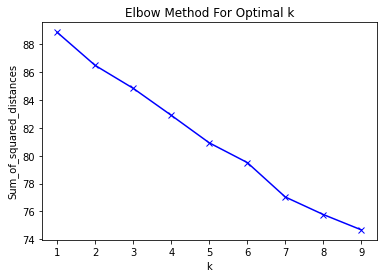

In [ ]:
plt.plot(K,Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# 1: A comprehensive overview of the markers / features

Hier vorerst Marker und Features aus der Folie. Mehr kann durch Analyse der Texte oder dem Erstellen eines Dictionaries herausgefunden werden.

In [ ]:
markers = ["Eosinopenia", "Basopenia", "IgT-anti-TPO", "CRP", "IgE"]
features = ["Activity", "Duration", "Comorbid autoimmune diseases", "Angioedema"]

def find_markers(text):
  found_markers = []
  for marker in markers:
    if marker.upper() in text.upper():
      found_markers.append(marker)
  return found_markers

def find_features(text):
  found_features = []
  for feature in features:
    if feature.upper() in text.upper():
      found_features.append(feature)
  return found_features

df['Markers'] = df['Corpus'].apply(find_markers)
df['Features'] = df['Corpus'].apply(find_features)
df

,Name,Tags,Year,Content,Corpus,Markers,Features
CAPTUM_Allergic Diseases_Omalizumab_Miller 2008.pdf_out_text.txt,Miller 2008.pdf,"[Allergic Diseases, Omalizumab]",2008,"[clinic, molecular, allergi, review, sever, as...",clinic molecular allergi review sever asthma o...,[IgE],[Angioedema]
CAPTUM_ASST_TPO_Chanprapaph 2018 .pdf_out_text.txt,Chanprapaph 2018 .pdf,"[ASST, TPO]",018,"[hindawi, biom, research, intern, volum, artic...",hindawi biom research intern volum articl page...,[IgE],[Angioedema]
CAPTUM_Angioedema_Antihistamine_Büyüköztürk 2012.pdf_out_text.txt,Büyüköztürk 2012.pdf,"[Angioedema, Antihistamine]",2012,"[japanes, dermatolog, associ, doi, origin, art...",japanes dermatolog associ doi origin articl jo...,[IgE],[Angioedema]
CAPTUM_Allergic Diseases_Duration_Karaayvaz 2002.pdf_out_text.txt,Karaayvaz 2002.pdf,"[Allergic Diseases, Duration]",2002,"[taylor, franci, taylor, franci, group, journa...",taylor franci taylor franci group journal derm...,"[CRP, IgE]",[Angioedema]
CAPTUM_ASST_angioedema_Magen 2011.pdf_out_text.txt,Magen 2011.pdf,"[ASST, angioedema]",2011,"[clinic, laboratori, featur, antihistamine-res...",clinic laboratori featur antihistamine-resist ...,"[Basopenia, CRP, IgE]","[Activity, Angioedema]"
...,...,...,...,...,...,...,...
CAPTUM_BAT_TPO_Sanchez 2019.pdf_out_text.txt,Sanchez 2019.pdf,"[BAT, TPO]",2019,"[allergi, asthma, immunol, re, jan, http, piss...",allergi asthma immunol re jan http pissn origi...,[IgE],[Angioedema]
CAPTUM_Thyroglobulin_Omalizumab_Asero 2020.pdf_out_text.txt,Asero 2020.pdf,"[Thyroglobulin, Omalizumab]",2020,"[ical, experiment, immunolog, elit, leclrem, l...",ical experiment immunolog elit leclrem lela §o...,[IgE],[Angioedema]
CAPTUM_Antihistamine_Omalizumab_Kaplan 2013.pdf_out_text.txt,Kaplan 2013.pdf,"[Antihistamine, Omalizumab]",2013,"[atop, dermat, skin, diseas, omalizumab, patie...",atop dermat skin diseas omalizumab patient sym...,"[Basopenia, IgE]",[Angioedema]
CAPTUM_Allergic Diseases_Omalizumab_Crisafulli 2019.pdf_out_text.txt,Crisafulli 2019.pdf,"[Allergic Diseases, Omalizumab]",2019,"[crisa, italian, journal, pediatr, http, earch...",crisa italian journal pediatr http earch itali...,[IgE],[Angioedema]


# 2: To understand how the markers/features of Type IIb aiCSU are linked


## How strong is the link between any two given markers? ​

Erste Definition Julian:
 $$link=\frac{AB}{\frac{A+B}{2}}$$


In [ ]:
def str_contains(text, a, b):
  if a in text:
    if b in text:
      return True
  return False

def get_link(a, b):
  if a == b:
    return 1
  # count_a = df[df.Markers.str.join(',').str.contains(a)].Markers.count()
  # count_b = df[df.Markers.str.join(',').str.contains(b)].Markers.count()
  # count_ab = df[df.Markers.str.join(',').str.contains(b)].Markers.count()
  count_a = df[df.Markers.apply(str_contains, a=a, b=a)].Markers.count()
  count_b = df[df.Markers.apply(str_contains, a=b, b=b)].Markers.count()
  count_ab = df[df.Markers.apply(str_contains, a=a, b=b)].Markers.count()
  return (count_ab/(0.5*(count_a+count_b)))


link = get_link(markers[0], markers[1])
link
# df_x = df[df['Markers'].isin(['IgE'])]
# df_x
# df_x = df[all(x in  for x in [])]['Markers'].count()
# df_x = df.Markers.to_list()
# all(x in ['b', 'a', 'foo', 'bar'] for x in ['a', 'b'])

# all(x in ['b', 'a', 'foo', 'bar'] for x in ['a', 'b'])
# df_x


# df[str_contains(df.Markers.str.join(','), , )]

# df['Markers'].apply(str_contains, a = 'CRP', b='IgE')

0.31

In [ ]:
# df_markers = pd.DataFrame()
# for marker_a in markers:
#   df_markers[marker_a] = []
#   #marker_links = []
#   for marker_b in markers:
#     df_markers = df_markers[marker_a].append(pd.Series(get_link(marker_a, marker_b)))
#   #df_markers.append(marker_links)
# df_markers

# mylist = []
# for marker in markers:
#   mylist.append(markers)

# mylist

# df_markers = pd.DataFrame(markers, columns=markers)
# df_markers


df_markers = pd.DataFrame(index=markers, columns=markers)
df_markers

for marker_a in markers:
  for marker_b in markers:
    df_markers[marker_a][marker_b] = get_link(marker_a, marker_b)

df_markers

,Eosinopenia,Basopenia,IgT-anti-TPO,CRP,IgE
Eosinopenia,1,0.31,0,0.176638,0.0685484
Basopenia,0.31,1,0,0.360248,0.295374
IgT-anti-TPO,0,0,1,0,0
CRP,0.176638,0.360248,0,1,0.456471
IgE,0.0685484,0.295374,0,0.456471,1


## Did the publication show a difference for marker a in patients stratified by marker b (and vice versa) and how big was the difference? ​

## Did the publication show a correlation between a and b and how strong was it? ​

## Was the result of a study that showed a link between a and b reproducible? ​


## How many studies confirmed the link? 

## How many studies failed to reproduce the link? ​

## How good is the quality of the study that demonstrates a link (how many patients?, how well characterized?, multicenter?, prospective vs retrospective, etc….)?